![alt text](http://www.kolblab.org/Pics/pk.cumulative.abstract.wordle.20141201.w.png)

## REDFRAG
### REDuced graph FRAGment-based similarity searching

![alt text](page-01.png)

## The MedChem Dogma
### *You reap what you sow*

![alt text](page-02.png)

## Dogmatic exploitation
### *Compound activity prediction by similarity*

![alt text](page-03.png)

## Compound similarity
### *The holistic approach*

![alt text](page-04.png)

## Compound similarity
### *Type nodes and compare the colors*

![alt text](page-05.png)

## Compound similarity
### *Cut into pieces and calculate fingerprint-based similarity*

![alt text](page-06.png)

## Compound similarity
### *Scoring of the graph-derived MCS*

![alt text](page-07.png)

## Validation
### *Retrospective + prospective*

![alt text](page-08.png)

## the redfrag python module
### additional modules
  - RDKit
  - networkx

## reduced graphs and the RDKit
  

### let us start with a pair of molecules *mol_r* and *mol_t*

In [22]:
import rdkit.Chem.Draw.IPythonConsole as rdipc
from redfrag import rdchem
from redfrag import rdall
from redfrag import rftools

mol_r = rdchem.MolFromSmiles('c1ccc(c(c1)COc2ccc(cc2CNCCNC(=O)c3c(non3)N)Br)F')
mol_t = rdchem.MolFromSmiles('COc1ccc(c(c1OC)OC)CNCCNC(=O)c2ccco2')
mol_r.id = "reference"
mol_t.id = "target"

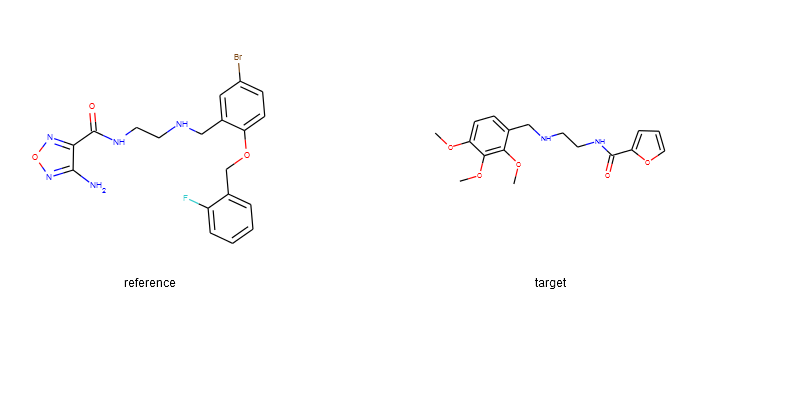

In [23]:
rdall.Compute2DCoords(mol_r)
rdall.Compute2DCoords(mol_t)
rftools.draw_molecules([mol_r, mol_t])

### reduced graph from a molecule
  
#### a high-level method

In [24]:
rfg_r = rftools.rfgraph_from_molecule(mol_r)
rfg_r.id = "I am an RFGraph."
rfg_r

I am an RFGraph.
0   1   [*]Cc1ccccc1F       
1   2   [*]Cc1cc(Br)ccc1O[*]
2   2   [*]N[*]             
3   2   [*]CC[*]            
4   2   [*]N[*]             
5   1   [*]C(=O)c1nonc1N    

### step-by-step to a reduced graph
  
#### 1\. flag & get *breakable* bonds
<br />
```python
def flag_breakable_bonds(molecule):

    for bond in rfdefs.rfrecap_bonds.values():
        matches = molecule.GetSubstructMatches(rdchem.MolFromSmarts(bond))
        for l, r in matches:
            molecule.GetBondBetweenAtoms(l, r).SetIntProp(rfdefs.rfbrekable, 1)
    return(True)
```
```python
def get_breakable_bonds(molecule):

    bonds = list()
    ...
    for bond in molecule.get_bonds(unary_predicate):
        bonds.append(RFBreakableBond(bond))
    return(bonds)
```

In [25]:
from redfrag.rffragmenter import RFRECAPFragmenter as rfrecap

rfrecap.flag_breakable_bonds(mol_r)
bonds = rfrecap.get_breakable_bonds(mol_r)

#### 2\. cleave breakable bonds & create fragments
```python
def get_fragments(molecule):

    ...
    fragmentpattern = rdchem.FragmentOnBonds(molecule, bondidxs, dummyLabels = labels)
    fragments = list(rdchem.GetMolFrags(fragmentpattern, asMols = True))
    atommappings = [map(int, mapping) for mapping in rdchem.GetMolFrags(fragmentpattern)]
    ...
    return(fragments)
```

In [26]:
bondidxs = [bond.idx for bond in bonds]
labels = [(i + 1, i + 1) for i in xrange(len(bonds))]

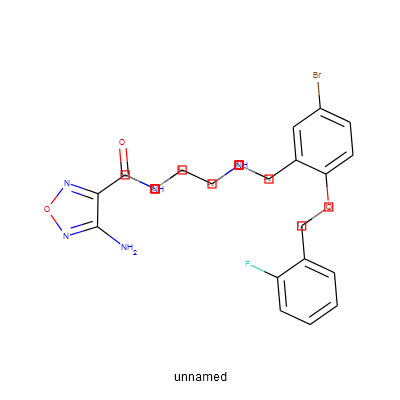

In [27]:
fragmentpattern = rdchem.FragmentOnBonds(mol_r, bondidxs, dummyLabels = labels)
rftools.draw_molecule(fragmentpattern)

In [28]:
fragments = list(rdchem.GetMolFrags(fragmentpattern, asMols = True))
fragments

[[*]Cc1ccccc1F,
 [*]Cc1cc(Br)ccc1O[*],
 [*]N[*],
 [*]CC[*],
 [*]N[*],
 [*]C(=O)c1nonc1N]

#### 3\. retrieve molecule topology
<br />
```python
def get_connections(fragments, ...):

    ...
    for fragment in fragments:
        ...
        fragment.connections.add(idx)
        ...
```

### 1-2-3 wrapper method

In [29]:
frags_r = rfrecap.decompose(mol_r)
for i, frag in enumerate(frags_r):
    print "{} {:<20}".format(i,frag), frag.connections

0 [*]Cc1ccccc1F        set([1])
1 [*]Cc1cc(Br)ccc1O[*] set([0, 2])
2 [*]N[*]              set([1, 3])
3 [*]CC[*]             set([2, 4])
4 [*]N[*]              set([3, 5])
5 [*]C(=O)c1nonc1N     set([4])


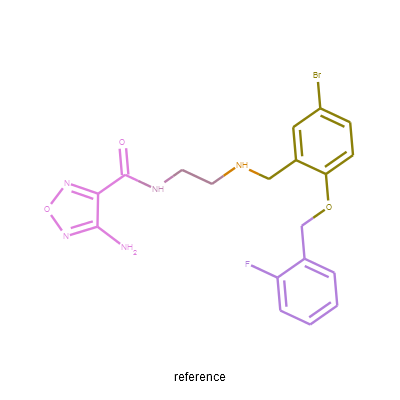

In [30]:
rftools.draw_molecule(mol_r, frags_r)

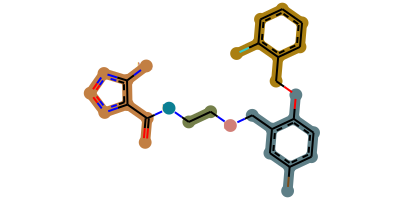

In [31]:
rftools.draw_molecule_svg(mol_r, frags_r)

#### 4\. RFGraph construction

In [32]:
from redfrag import rfgraph

rfg_r = rfgraph.RFGraph(mol_r, frags_r)
rfg_r.id = "I am an RFGraph."
rfg_r

I am an RFGraph.
0   1   [*]Cc1ccccc1F       
1   2   [*]Cc1cc(Br)ccc1O[*]
2   2   [*]N[*]             
3   2   [*]CC[*]            
4   2   [*]N[*]             
5   1   [*]C(=O)c1nonc1N    

#### 5\. fragment sanitization & node typing

In [33]:
rftools.sanitize_nodes(rfg_r)
for i, node in rfg_r.get_nodes():
    print i, node.molecule.fingerprint

0 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x07502228>
1 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x074FD228>
2 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x074FD148>
3 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x074FD3E8>
4 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x074FD458>
5 <rdkit.DataStructs.cDataStructs.ExplicitBitVect object at 0x074FD810>


#### 5\. fragment sanitization with dummy atom removal and explicit replacement

In [34]:
rftools.sanitize_nodes(rfg_r, rmdummy = True, explicit = True)
rfg_r

I am an RFGraph.
0   1   Fc1ccccc1C[Ag]      
1   2   Brc1ccc(O[Au])c(C[Ag])c1
2   2   [Au]N[Au]           
3   2   [Ag]CC[Ag]          
4   2   [Au]N[Au]           
5   1   Nc1nonc1C(=O)[Ag]   

#### 6\. RFGraph visualization

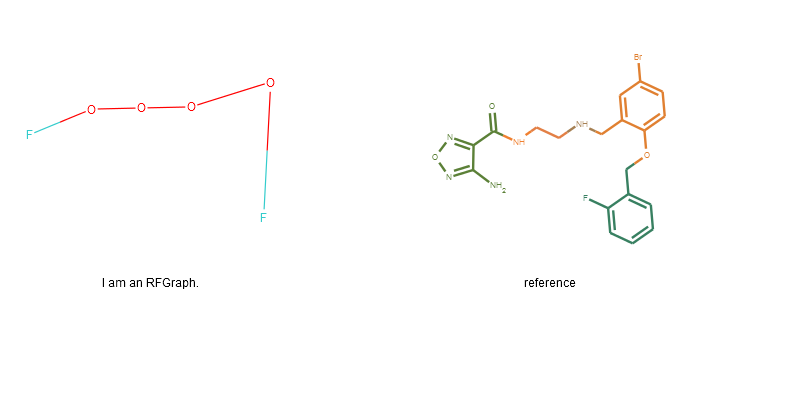

In [35]:
rfm_r = rftools.molecule_from_rfgraph(rfg_r)
rftools.draw_molecules([rfm_r, mol_r], fragments=[None, frags_r])

#### ... and what they are also good for

![Alt text](image-04.png)

![Alt text](pymol-22.png)

## scoring a pair of RFGraphs
### remember, there were two of them ...

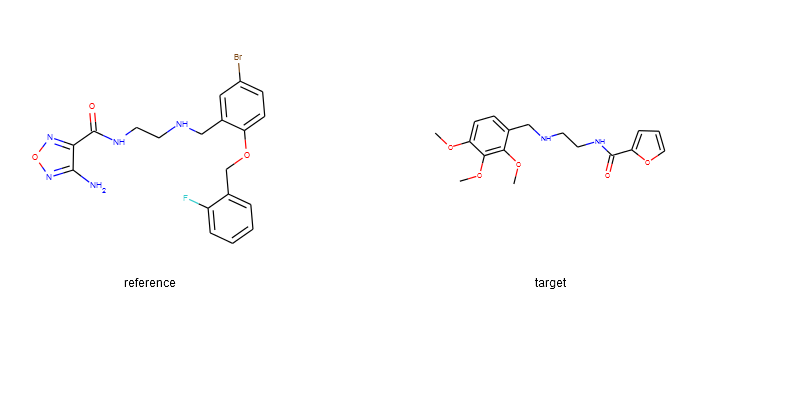

In [36]:
rftools.draw_molecules([mol_r, mol_t])

### let us hack the other molecule into pieces ...

In [37]:
rfg_t = rftools.rfgraph_from_molecule(mol_t)
rfg_t.id = "I am an RFGraph, too!"
rfg_t

I am an RFGraph, too!
0   1   [*]Cc1ccc(OC)c(OC)c1OC
1   2   [*]N[*]             
2   2   [*]CC[*]            
3   2   [*]N[*]             
4   1   [*]C(=O)c1ccco1     

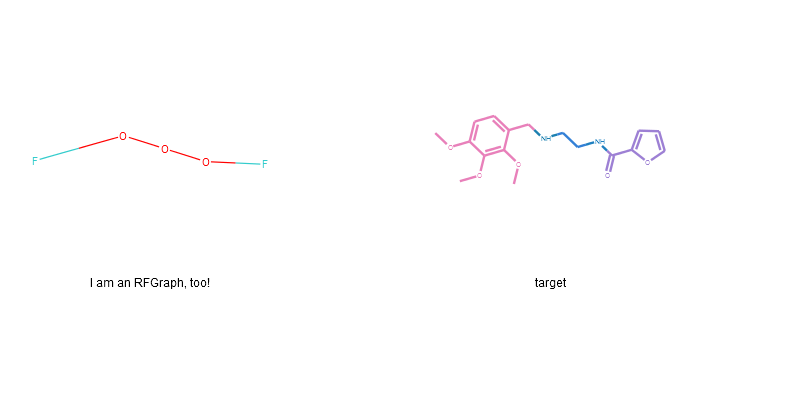

In [38]:
rfm_t = rftools.molecule_from_rfgraph(rfg_t)
rftools.draw_molecules([rfm_t, mol_t], fragments=[None, [node.molecule for _, node in rfg_t.get_nodes()]])

### ... and use a high-level RFGraph scorer to get a score

In [39]:
rftools.score_rfgraphs(rfg_r, rfg_t)

array([ 0.7549,  0.8333,  0.6764])

### we can use the two molecules *mol_r* and *mol_t* directly ...

In [40]:
rftools.score_rfgraphs_from_molecules(mol_r, mol_t)

array([ 0.7937,  0.8333,  0.7541])

### ... and even without fragmentation (just for comparison)

In [41]:
rftools.score_molecules(mol_r, mol_t)

array([ 0.6053])

## visualization of the MCS

### highlighting the pairwise fragment matchings

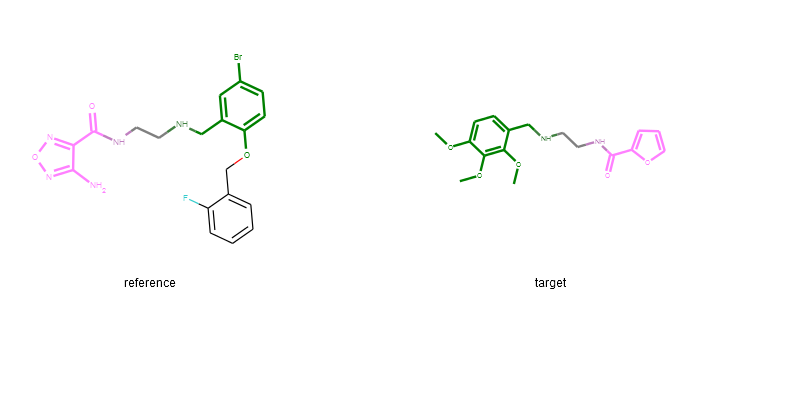

In [42]:
rftools.draw_mcs([mol_r, mol_t])

# the redfrag python module
<br />
## yet another view onto similarity ...
  - graph reduction of small molecules
  - topological & fragmental similarity estimation
  - abstract view of molecules
  - high customizability
  - many posibilites to tweak & tune & play

-   
    - fragmentation patterns
    - graph compression
    - similarity threshold
    - score weighting

## REDFRAG
### REDuced graph FRAGment-based similarity searching

![alt text](page-01.png)